# Question 1: Predicting air quality measurements near methane emitter sources

##### **To use as a feature for prediction questions 2 & 3**
We'd like to use air quality as a feature in our model; however, we don't have air quality measurements at the exact location of our emitter points. Therefore, we'll use K Nearest Neighbors to predict the monthly average air quality at our emitter points, and use these predictions as a feature for our main prediction questions. 

In [41]:
#Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [4]:
#pip install sklearn

First, we'll load in and take a look at our air quality data. 

In [442]:
#Load data
airnow = gpd.read_file('Data/airnow_monthly_averages.json/airnow_monthly_averages.shp')

In [15]:
airnow.head()

,Latitude,Longitude,Parameter,Unit,Category,SiteName,AgencyName,FullAQSCod,IntlAQSCod,year,month,Value_mean,Value_coun,RawConcent,RawConce_1,AQI_mean,AQI_count,geometry
0,32.7355,-116.3454,PM10,UG/M3,0,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,1,-0.150000,2,0.000000,2,NaN,0,POINT (-116.34540 32.73550)
1,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,1,2.933515,734,2.922131,732,2.750681,734,POINT (-116.34540 32.73550)
2,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,2,5.725291,3440,5.867347,3430,5.306686,3440,POINT (-116.34540 32.73550)
3,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,3,7.577446,2944,7.586957,2944,7.009511,2944,POINT (-116.34540 32.73550)
4,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,4,11.366199,2139,11.404494,2136,10.531557,2139,POINT (-116.34540 32.73550)


In [112]:
airnow.shape

(17348, 18)

In [17]:
#Look at unique air quality parameters
airnow['Parameter'].unique()

array(['PM10', 'OZONE', 'PM2.5', 'CO', 'NO2', 'SO2'], dtype=object)

In [226]:
#Let's see how many observations there are for each parameter
print(airnow[airnow['Parameter'] == 'PM2.5'].shape)
print(airnow[airnow['Parameter'] == 'PM10'].shape)
print(airnow[airnow['Parameter'] == 'OZONE'].shape)
print(airnow[airnow['Parameter'] == 'CO'].shape)
print(airnow[airnow['Parameter'] == 'NO2'].shape)
print(airnow[airnow['Parameter'] == 'SO2'].shape)

(4944, 18)
(2504, 18)
(7008, 18)
(952, 18)
(1550, 18)
(390, 18)


In [532]:
#Let's see how many measurements there are per year & month
print(airnow[(airnow['Parameter'] == 'CO') & (airnow['month'] == 1) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'SO2') & (airnow['month'] == 1) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'PM2.5') & (airnow['month'] == 1) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'PM10') & (airnow['month'] == 1) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'NO2') & (airnow['month'] == 1) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'OZONE') & (airnow['month'] == 1) & (airnow['year'] == 2016)].shape)

(23, 18)
(13, 18)
(169, 18)
(68, 18)
(33, 18)
(135, 18)


Because the variation in air quality measurements between locations might vary by month, year, and the air quality parameter (due to wildfires and other events that might impact air quality), we'll want to subset our data by month, year, and parameter before training our model. 

For our model, we'll use `scikitlearn`'s KNN regression, which is used for continuous data, and is computed based on the mean of the K Nearest Neighbors. Because `scikitlearn`'s KNN regression finds the nearest neighbor in **feature space**, and our goal is to find the nearest neighbor in **physical space**, we will train our model with only the lat/lon coordinates, so that the model is finding the nearest neighbor in physical space. 

The hyperparameter we'll want to test is the k value that gives us the lowest error, as measured by Root Mean Squared Error. We can us `scikitlearn`'s `GridSearchCV` to find the optimal k value for each month/year/parameter combo. Another parameter that we can test for KNN regression is `weights`: scikitlearn gives us the option to specify the weight function used in prediction; either uniform weights, or inverse distance weighting. 

Below, we'll create a function where we input the AirNow dataframe, parameter, year, month, and an array of K values, and we'll use `scikitlearn` to fit the model and return the model (which we can then use to predict the air quality measurements at the emitter location for that month, year, and parameter), the parameter specifications, and the RMSE. Note: `GridSearchCV` allows us to specify which scoring parameter we'd like to use. Since it follows the convention that higher return values are better than lower return values, MSE & RMSE are available as negated values. 

We'll use Kfold cross validation with 10 folds to test the performance of our model. Since we are not testing between different types of models, just tuning the hyperparameters, we will not set aside a separate test set. 

In [537]:
#Define a function to train the model and find the optimal hyperparameters. 

def KNN(df, parameter, year, month, k):
    """Fits a KNN model for a specific air quality parameter, averaged over a given month, in a given year. 
    Arguments:
        dataframe: the Air Now dataframe. 
        parameter (string): Air quality measurement parameter: PM10, OZONE, PM2.5, CO, NO2, SO2
        year: year to use to fit model, 2016 or 2017
        month: month to use to fit model (1-12)
        k: an array of k values to test for fitting model
    Returns:
        model: the trained model
        opt_k: the optimal k value
        opt_score: the mean MSE of the optimal k value
        """
    
    #Filter data to month, year, and parameter
    data = df[(df['Parameter'] == parameter) & (df['year'] == year) & (df['month'] == month)]
    X = data.loc[:, 'Latitude':'Longitude'].copy()
    y = data['Value_mean']
    
    #knn model object
    knn = KNeighborsRegressor()
    
    #create dictionary of parameter values
    param_grid = {'n_neighbors': k, 'weights': ['uniform', 'distance']}
    
    #specify hyperparameters
    knn_cv = GridSearchCV(knn, param_grid, scoring = 'neg_root_mean_squared_error', cv = 10)
    
    #fit model
    model = knn_cv.fit(X,y)
    
    return model, model.best_params_, model.best_score_
    

For our methane emitters, we have data from the following dates: Sept, Oct, and Nov 2016, & March, June, Aug, Sept, Oct, & Nov 2017. Let's fit a model and see how our KNN model performs for each of these combinations. 

Note that in this run, we had to remove SO2 and CO since there were so few values that when subsetted by a specific month/year, the number of observations was lower than the K values we wanted to try. 

In [533]:
#Set up parameters to run through the loop
parameters = ['PM10', 'OZONE', 'PM2.5', 'NO2'] #Remove SO2 & CO since there are so few values
dates = np.array([[9, 2016], [10, 2016], [11, 2016], [3, 2017], [6, 2017], [8, 2017], [9, 2017], [10, 2017], [11, 2017]])

In [538]:
#Run through loop for to fit model each date/time/parameter combo
RMSE_array = np.zeros((4, 9))
for i in range(len(parameters)):
    for j in range(len(dates)):
        _, params, RMSE = KNN(airnow, parameters[i], dates[j, 1], dates[j, 0], np.arange(1, 11))
        print(str(dates[j, 0]) + '/' + str(dates[j, 1]) + ' ' + str(parameters[i]) + ' parameters:', params)
        print(str(dates[j, 0]) + '/' + str(dates[j, 1]) + ' ' + str(parameters[i]) + ' RMSE:', RMSE)  
        RMSE_array[i, j] = RMSE

9/2016 PM10 parameters: {'n_neighbors': 4, 'weights': 'uniform'}
9/2016 PM10 RMSE: -44.36242672442914
10/2016 PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
10/2016 PM10 RMSE: -108.66556787641714
11/2016 PM10 parameters: {'n_neighbors': 2, 'weights': 'uniform'}
11/2016 PM10 RMSE: -81.29035048565508
3/2017 PM10 parameters: {'n_neighbors': 9, 'weights': 'uniform'}
3/2017 PM10 RMSE: -184.16412464034593
6/2017 PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
6/2017 PM10 RMSE: -25.52769365265195
8/2017 PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
8/2017 PM10 RMSE: -23.912737082428396
9/2017 PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
9/2017 PM10 RMSE: -115.1153944609044
10/2017 PM10 parameters: {'n_neighbors': 6, 'weights': 'uniform'}
10/2017 PM10 RMSE: -111.09420866638268
11/2017 PM10 parameters: {'n_neighbors': 2, 'weights': 'uniform'}
11/2017 PM10 RMSE: -104.30978991341956
9/2016 OZONE parameters: {'n_neighbors': 9, 'weights': 'uniform'}

<ipython-input-539-64aefc9a4b61>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])


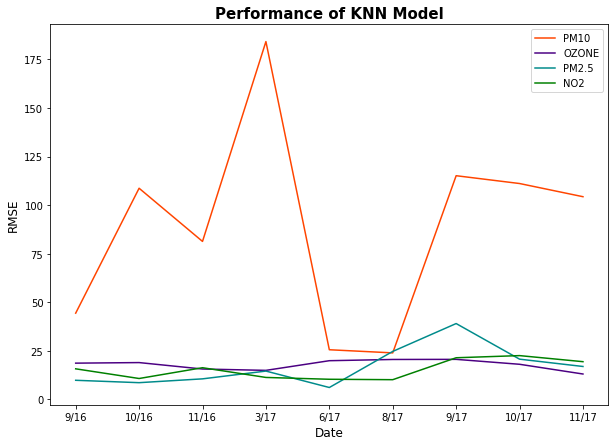

In [539]:
#Plot RMSEs
fig, ax = plt.subplots(figsize = (10, 7))
plt.title('Performance of KNN Model', size = 15, fontweight = 'bold')
plt.ylabel('RMSE', size = 12)
plt.xlabel('Date', size = 12)
ax.plot(np.arange(1,10), abs(RMSE_array[0, :]), label = 'PM10', color = 'orangered')
ax.plot(np.arange(1,10), abs(RMSE_array[1,:]), label = 'OZONE', color = 'indigo')
ax.plot(np.arange(1,10), abs(RMSE_array[2,:]), label = 'PM2.5', color = 'darkcyan')
ax.plot(np.arange(1,10), abs(RMSE_array[3,:]), label = 'NO2', color = 'green')
ax.set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])
plt.legend()

From this graph, we can see that the variance in performance of PM10 is the greatest, while the RMSE for the other air quality parameters hovers around 30 or below. We can also see from our loop above that the optimal k value varies widely. 

Let's also see how our model performs if we don't subset by time, but do subset by air quality parameter. 

In [540]:
#Define a function to train the model and find the optimal hyperparameters. 

def KNN_param(df, parameter, k):
    """Fits a KNN model for a specific air quality parameter. 
    Arguments:
        dataframe: the Air Now dataframe. 
        parameter (string): Air quality measurement parameter: PM10, OZONE, PM2.5, CO, NO2, SO2
        k: an array of k values to test for fitting model
    Returns:
        model: the trained model
        opt_k: the optimal k value
        opt_score: the mean MSE of the optimal k value
        """
    
    #Filter data to month, year, and parameter
    data = df[df['Parameter'] == parameter]
    X = data.iloc[:, 0:2].copy()
    y = data['Value_mean']
    
    #knn model object
    knn = KNeighborsRegressor()
    
    #create dictionary of parameter values
    param_grid = {'n_neighbors': k, 'weights': ['uniform', 'distance']}
    
    #specify hyperparameters
    knn_cv = GridSearchCV(knn, param_grid, scoring = 'neg_root_mean_squared_error', cv = 10)
    
    #fit model
    model = knn_cv.fit(X,y)
    
    return model, model.best_params_, model.best_score_

In [542]:
#Run through loop for to fit model for each parameter 
parameters_2 = np.array(['PM10', 'OZONE', 'PM2.5','NO2', 'CO','SO2']) #Return SO2 & CO
for i in range(len(parameters_2)):
    _, params, RMSE = KNN_param(airnow, parameters_2[i], np.arange(1, 11))
    print(str(parameters_2[i]) + ' parameters:', params)
    print(str(parameters_2[i]) + ' RMSE:', RMSE)  

PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
PM10 RMSE: -144.06363852126987
OZONE parameters: {'n_neighbors': 10, 'weights': 'uniform'}
OZONE RMSE: -26.060713665353205
PM2.5 parameters: {'n_neighbors': 2, 'weights': 'uniform'}
PM2.5 RMSE: -25.546865504670063
NO2 parameters: {'n_neighbors': 1, 'weights': 'uniform'}
NO2 RMSE: -20.235770974784256
CO parameters: {'n_neighbors': 10, 'weights': 'distance'}
CO RMSE: -0.1913688255528013
SO2 parameters: {'n_neighbors': 4, 'weights': 'distance'}
SO2 RMSE: -12.29393206799217


Now, that we've taken a look at how the model performs, we create a function to use the fitted optimal model for any given month/year/parameter to predict that air quality parameter value for the corresponding month/year of each observation in our dataset, using the latitudes and longitudes of the emitter points, and append a column with those predicted values. 

In [543]:
def predict_AQ(airnow, emitter, parameter, dates, k):
    """Fits a KNN model for a specific air quality parameter averaged over a given month, in a given year. 
    Uses that model to predict the air quality measure at the emitter point location in that month and year 
    and appends the prediction to the dataframe.
    Arguments:
        airnow: the Air Now dataframe. 
        emitter: the methane emitter dataframe
        parameter (string): Air quality measurement parameter: PM10, OZONE, PM2.5, CO, NO2, SO2
        dates: an 2darray of the month/year combos to fit; the year/month combos that appear in the emitter dataset.
            Should follow format [month (1-12), year (2016 or 2017)]
        k: an array of k values to test for fitting model
    Returns:
        model: the trained model
        opt_k: the optimal k value
        opt_score: the mean MSE of the optimal k value
        """
    
    #add column to store predicted air quality measure
    emitter[parameter] = 0
    
    #Fit model & get prediction for every year/month combo 
    for i in range(len(dates)): 
        #fit the model for each month/date combo in dates
        model, _, _ = KNN(airnow, parameter, dates[i, 1], dates[i, 0], np.arange(1, 11)) 
        #For any corresponding observations with that same date/month combo, predict the air quality value and append
        for j in range(len(emitter)):
            if (emitter['month'][j] == dates[i,0]) & (emitter['year'][j] == dates[i,1]):
                X = np.array([ch4['geometry'][j].centroid.y, ch4['geometry'][j].centroid.x]).reshape(1,-1)
                y_pred = model.predict(X)
                emitter.loc[j, parameter] = y_pred
    
    return emitter

In [308]:
#Test with current VISTA File
ch4 = gpd.read_file('Data/CH4_Emitters_All_2.geojson')

In [318]:
#Add month and year to test
ch4['month'] = 11
ch4['year'] = 2017

In [545]:
predictions = predict_AQ(airnow, ch4, 'PM2.5', dates, np.arange(1,11))

In [546]:
predictions.head()

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,County,geometry,PM2.5,month,year
0,37.72799,-120.89865,4B Biological Treatment of Solid Waste,"3D Ag, LLC",Composting Sites,CMP000001,2019-08-20,CA,Oakdale,CalRecycle,None,"POLYGON ((-120.89865 37.72808, -120.89863 37.7...",14.130969,11,2017
1,33.70999,-117.32864,4B Biological Treatment of Solid Waste,"A. Lua Recycling, Inc.",Composting Sites,CMP000002,2019-08-20,CA,Lake Elsinore,CalRecycle,None,"POLYGON ((-117.32864 33.71008, -117.32862 33.7...",13.769223,11,2017
2,38.01667,-122.13333,4B Biological Treatment of Solid Waste,Acme Composting Compost Facility,Composting Sites,CMP000003,2019-08-20,CA,Martinez,CalRecycle,None,"POLYGON ((-122.13333 38.01676, -122.13331 38.0...",12.845011,11,2017
3,34.03281,-118.35424,4B Biological Treatment of Solid Waste,Adams Garden Supply,Composting Sites,CMP000004,2019-08-20,CA,Los Angeles (City),CalRecycle,None,"POLYGON ((-118.35424 34.03290, -118.35422 34.0...",26.528631,11,2017
4,34.44517,-117.29007,4B Biological Treatment of Solid Waste,Advance Disposal Center for the Environm,Composting Sites,CMP000005,2019-08-20,CA,Hesperia,CalRecycle,None,"POLYGON ((-117.29007 34.44526, -117.29005 34.4...",11.503858,11,2017


In [547]:
#Check unique values of predictions
predictions['PM2.5'].unique()

array([14.13096911, 13.76922259, 12.84501064, 26.52863122, 11.50385803,
        9.88409372, 11.90470334, 15.30202928, 15.21821258, 11.2014425 ,
        2.72209273, 30.21849704,  2.58767919,  9.09228467, 10.43211696,
       15.12044833, 10.01138663,  6.20491361,  7.20958333, 32.29692421,
       11.01716735, 10.25856847, 12.21546072, 10.63908331,  5.2882298 ,
       14.97101754,  9.05245763, 11.22849277, 11.37036884, 11.48393189,
        1.45771795, 11.58059667,  2.47324215,  9.21178523,  4.72338765,
        9.98130028, 32.17717087, 13.60900464, 12.93082237,  3.36483491,
       13.24088824,  2.09093137, 32.88764045, 13.55508943, 12.55307174,
       10.13621827, 13.29623762, 10.67810174,  7.40255803,  4.36146885,
       15.21017119, 14.08068068,  9.55043936, 12.07666084, 13.20257502,
       12.45116401,  8.89818518, 11.38616639, 14.38131652, 13.51255915,
        4.49126777, 22.13814766,  4.0713885 ,  5.74054399, 11.43947637,
        5.69817672, 13.06416667, 11.75741554,  2.88910006, 32.12

In [553]:
#Compare with airnow to ensure range of values seems reasonable
airnow[(airnow['Parameter'] == 'PM2.5') & (airnow['month'] == 11) & (airnow['year'] == 2017)]

,Latitude,Longitude,Parameter,Unit,Category,SiteName,AgencyName,FullAQSCod,IntlAQSCod,year,month,Value_mean,Value_coun,RawConcent,RawConce_1,AQI_mean,AQI_count,geometry
74,32.789561,-116.944222,PM2.5,UG/M3,1,El Cajon - Lexington Elementary School,San Diego APCD,060731022,840060731022,2017,11,7.957407,756,7.612533,750,33.148148,756,POINT (-116.94422 32.78956)
93,32.789561,-116.944222,PM2.5,UG/M3,2,El Cajon - Lexington Elementary School,San Diego APCD,060731022,840060731022,2017,11,14.814925,670,15.275375,666,56.695522,670,POINT (-116.94422 32.78956)
226,32.792097,-115.563018,PM2.5,UG/M3,1,MMCA81011,California Air Resources Board,MMCA81011,840MMCA81011,2017,11,7.704706,340,7.616352,318,32.129412,340,POINT (-115.56302 32.79210)
230,32.792097,-115.563018,PM2.5,UG/M3,2,MMCA81011,California Air Resources Board,MMCA81011,840MMCA81011,2017,11,15.263158,114,15.370370,108,57.649123,114,POINT (-115.56302 32.79210)
335,32.842297,-116.768326,PM2.5,UG/M3,1,Alpine,San Diego APCD,060731006,840060731006,2017,11,4.895091,1426,4.909348,1412,20.444600,1426,POINT (-116.76833 32.84230)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16918,40.301899,-121.235001,PM2.5,UG/M3,1,Chester BAM,Northern Sierra AQMD,60631007,840060631007,2017,11,10.920641,562,10.664260,554,45.587189,562,POINT (-121.23500 40.30190)
16939,40.301899,-121.235001,PM2.5,UG/M3,2,Chester BAM,Northern Sierra AQMD,60631007,840060631007,2017,11,14.462570,716,14.729577,710,55.935754,716,POINT (-121.23500 40.30190)
17010,40.453100,-122.297800,PM2.5,UG/M3,1,Anderson,Shasta County Air Quality Management District,060890007,840060890007,2017,11,10.429630,54,6.614815,54,43.481481,54,POINT (-122.29780 40.45310)
17034,40.453100,-122.297800,PM2.5,UG/M3,2,Anderson,Shasta County Air Quality Management District,060890007,840060890007,2017,11,19.512405,1322,19.695599,1318,66.606657,1322,POINT (-122.29780 40.45310)


If we want AQI Values, we can use the function below. 

In [113]:
#For AQI, note NAN observations need to be removed beforehand, since scikitlearn gives an error with NAN

def KNN_AQI(df, year, month, k):
    """Fits a KNN model for AQI, averaged over a given month, in a given year. 
    Arguments:
        dataframe: the Air Now dataframe. 
        year: year to use to fit model, 2016 or 2017
        month: month to use to fit model (1-12)
        k: an array of k values to test for fitting model
    Returns:
        model: the trained model
        opt_k: the optimal k value
        opt_score: the mean MSE of the optimal k value
        """
    
    #Filter data to month, year, and parameter
    data = df[(df['year'] == year) & (df['month'] == month)]
    X = data.iloc[:, 0:2].copy()
    y = data['AQI_mean']
    
    #knn model object
    knn = KNeighborsRegressor()
    
    #create dictionary of parameter values
    param_grid = {'n_neighbors': k, 'weights': ['uniform', 'distance']}
    
    #specifu hyperparameters
    knn_cv = GridSearchCV(knn, param_grid, scoring = 'neg_root_mean_squared_error', cv = 10)
    
    #fit model
    model = knn_cv.fit(X,y)
    
    return model, model.best_params_, model.best_score_